<a href="https://colab.research.google.com/github/thais-hanashiro/novos-piratas/blob/master/THAIS_HANASHIRO_ENTREGA3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importando bibliotecas

In [0]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import datetime

# Importando base de dados

In [2]:
# importando base de dados do drive local
from google.colab import files
uploaded = files.upload()

Saving features.csv to features.csv
Saving stores.csv to stores.csv
Saving test.csv to test.csv
Saving train.csv to train.csv


In [0]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_stores = pd.read_csv('stores.csv')
df_features = pd.read_csv('features.csv')

In [5]:
df_train.info()
df_train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
Store           421570 non-null int64
Dept            421570 non-null int64
Date            421570 non-null object
Weekly_Sales    421570 non-null float64
IsHoliday       421570 non-null bool
dtypes: bool(1), float64(1), int64(2), object(1)
memory usage: 13.3+ MB


,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


Alterando o formato das datas para nº de dias a partir de primeiro de janeiro de 2010

In [0]:
date_0 = pd.DataFrame(data=['2010-01-01'],columns=['Date'])
date_0['Date'] = pd.to_datetime(date_0['Date'])

In [0]:
df_train['Date']= pd.to_datetime(df_train['Date'])
df_train['Date_delta'] = (df_train['Date'] - date_0['Date'].min())/np.timedelta64(1,'D')

In [30]:
df_stores.head()

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875


In [31]:
df_features.head()

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,False
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,True
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,False
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,False
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,False


In [165]:
df_test.head()

,Store,Dept,Date,IsHoliday,Date_delta
0,1,1,2012-11-02,False,1036.0
1,1,1,2012-11-09,False,1043.0
2,1,1,2012-11-16,False,1050.0
3,1,1,2012-11-23,True,1057.0
4,1,1,2012-11-30,False,1064.0


# Preparando os sets

Criar um set de vallidação para não "gastar" o train set até encontar os 2 melhores algoritmos 


*   Dataset estratificado, para garantir representatividade dos dados quanto a presença de todas as lojas
 *  Strat_train_set
  * Strat_cv_set



In [0]:
from sklearn.model_selection import StratifiedShuffleSplit

In [0]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, cv_index in split.split(df_train, df_train["Store"]):
  strat_train_set = df_train.loc[train_index]
  strat_cv_set = df_train.loc[cv_index]

Verificando visualmente se a amostra é representativa: Checked

Text(0.5, 0, 'Período')

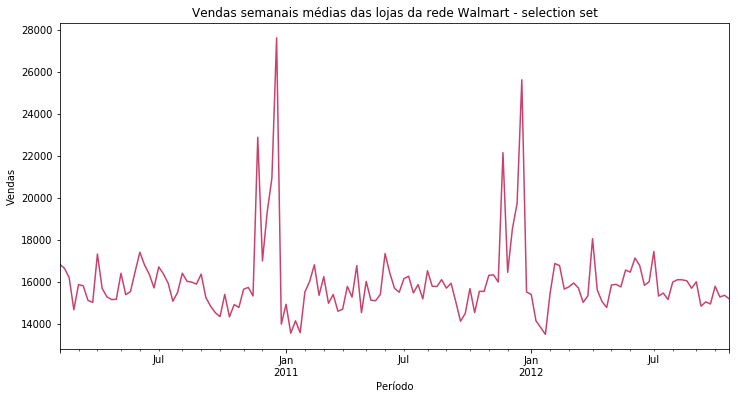

In [34]:
# ajustando tamanho da imagem
_ = plt.figure(figsize=(12, 6))
# agrupando dados das lojas por data e tomando sua média
_ = strat_train_set.groupby('Date')['Weekly_Sales'].mean().plot(color='xkcd:dark pink')
# configurações de estilo
_.set_title('Vendas semanais médias das lojas da rede Walmart - selection set')
_.set_ylabel('Vendas')
_.set_xlabel('Período')

In [0]:
X_train = strat_train_set[['Store','Dept','Date_delta','IsHoliday']]
y_train =  strat_train_set[['Weekly_Sales']]
X_cv = strat_cv_set[['Store','Dept','Date_delta','IsHoliday']]
y_cv = strat_cv_set[['Weekly_Sales']]

# Modelos de ML

In [0]:
from sklearn.metrics import mean_squared_error, max_error
from math import sqrt
from sklearn.model_selection import cross_validate

Comparacao = {}
scores = ['neg_mean_squared_error','max_error']

## K-Nearest Neighbors

### Modelo

In [0]:
from sklearn.neighbors import KNeighborsRegressor

In [111]:
knn = KNeighborsRegressor()
knn.fit(X_train,y_train)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                    weights='uniform')

In [0]:
y_knn_cv = knn.predict(X_cv)

### Métricas

In [113]:
rmse_knn = sqrt(MSE(y_cv,y_knn_cv))
rmse_knn

18280.212485848715

In [114]:
y_knn_cv = pd.DataFrame(y_knn_cv,index=y_cv.index,columns=['Weekly_Sales'])
y_knn_cv.head()

,Weekly_Sales
280010,13183.754
313317,45072.278
44320,7532.310
45420,10381.566
382417,8428.544


In [115]:
Max_dif_knn = (y_cv['Weekly_Sales'] - y_knn_cv['Weekly_Sales']).max()
Max_dif_knn

267238.668

In [0]:
Comparacao['knn']={'rmse':rmse_knn,'max_dif':Max_dif_knn}

In [0]:
cv_knn = cross_validate(knn, X_train, y_train, cv=10,scoring=scores)

In [0]:
fit_time_knn = cv_knn['fit_time'].max()
score_time_knn = cv_knn['score_time'].min()
max_error_knn = cv_knn['test_max_error'].max()
mse_knn = cv_knn['test_neg_mean_squared_error'].max()

In [0]:
Comparacao['knn']['fit_time']= fit_time_knn
Comparacao['knn']['score_time']=score_time_knn
Comparacao['knn']['max_error']=max_error_knn
Comparacao['knn']['mse']=mse_knn

## Polynomial Regression

### Modelo

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

In [0]:
poly_features = PolynomialFeatures(degree=6, include_bias=False)

In [0]:
X_poly = poly_features.fit_transform(X_train)

In [123]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [0]:
X_poly_cv = poly_features.fit_transform(X_cv)

In [0]:
y_poly_cv = lin_reg.predict(X_poly_cv)

### Métricas

In [0]:
y_poly_cv = pd.DataFrame(y_poly_cv,index=y_cv.index,columns=['Weekly_Sales'])

In [127]:
y_poly_cv.head()

,Weekly_Sales
280010,4445.802199
313317,32006.289309
44320,10427.654431
45420,13200.461386
382417,10418.581333


In [128]:
y_cv.head()

,Weekly_Sales
280010,15295.08
313317,48707.51
44320,2825.90
45420,17.94
382417,10938.36


In [129]:
Max_dif_poly = (y_cv['Weekly_Sales'] - y_poly_cv['Weekly_Sales']).max()
Max_dif_poly

360997.5494610581

In [130]:
rmse_poly = sqrt(MSE(y_cv,y_poly_cv))
rmse_poly

20448.188461559406

In [0]:
Comparacao['poly']={'rmse':rmse_poly,'max_dif':Max_dif_poly}

In [0]:
cv_poly = cross_validate(lin_reg, X_train, y_train, cv=10,scoring=scores)
fit_time_poly = cv_poly['fit_time'].max()
score_time_poly = cv_poly['score_time'].min()
max_error_poly = cv_poly['test_max_error'].max()
mse_poly = cv_poly['test_neg_mean_squared_error'].max()


In [0]:
Comparacao['poly']['fit_time']= fit_time_poly
Comparacao['poly']['score_time']=score_time_poly
Comparacao['poly']['max_error']=max_error_poly
Comparacao['poly']['mse']=mse_poly

##  Decision Tree

### Modelo

In [0]:
from sklearn.tree import DecisionTreeRegressor

In [73]:
dec_tree = DecisionTreeRegressor()
dec_tree.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=None, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [0]:
y_tree_cv = dec_tree.predict(X_cv)

### Métricas

In [0]:
y_tree_cv = pd.DataFrame(y_tree_cv,index=y_cv.index,columns=['Weekly_Sales'])

In [83]:
rmse_tree = sqrt(MSE(y_cv,y_tree_cv))
rmse_tree

6215.163352242798

In [77]:
dec_tree.get_depth()

54

In [86]:
Max_dif_tree = (y_cv['Weekly_Sales'] - y_tree_cv['Weekly_Sales']).max()
Max_dif_tree

206049.74

In [0]:
Comparacao['tree']={'rmse':rmse_tree,'max_dif':Max_dif_tree}

In [88]:
y_cv.head()

,Weekly_Sales
280010,15295.08
313317,48707.51
44320,2825.90
45420,17.94
382417,10938.36


In [0]:
cv_tree = cross_validate(lin_reg, X_train, y_train, cv=10,scoring=scores)
fit_time_tree = cv_tree['fit_time'].max()
score_time_tree = cv_tree['score_time'].min()
max_error_tree = cv_tree['test_max_error'].max()
mse_tree = cv_tree['test_neg_mean_squared_error'].max()

In [0]:
Comparacao['tree']['fit_time']= fit_time_tree
Comparacao['tree']['score_time']=score_time_tree
Comparacao['tree']['max_error']=max_error_tree
Comparacao['tree']['mse']=mse_tree

## Random Forest

### Modelo

In [0]:
 from sklearn.ensemble import RandomForestRegressor

In [0]:
Rand_forest =  RandomForestRegressor(random_state = 0)

In [142]:
Rand_forest.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

### Métricas

In [0]:
y_forest_cv = Rand_forest.predict(X_cv)

In [144]:
rmse_forest = sqrt(MSE(y_cv,y_forest_cv))
rmse_forest

4946.209391098486

In [145]:
Rand_forest.get_params(deep=True)

{'bootstrap': True,
 'criterion': 'mse',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 10,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 0,
 'verbose': 0,
 'warm_start': False}

In [146]:
[estimator.tree_.max_depth for estimator in Rand_forest.estimators_]
#profundidade das árvores da floresta

[39, 41, 39, 40, 39, 39, 39, 40, 45, 40]

In [0]:
y_forest_cv = pd.DataFrame(y_forest_cv,index=y_cv.index,columns=['Weekly_Sales'])

In [149]:
Max_dif_forest = (y_cv['Weekly_Sales'] - y_forest_cv['Weekly_Sales']).max()
Max_dif_forest

199723.598

In [0]:
Comparacao['forest']={'rmse':rmse_forest,'max_dif':Max_dif_forest}

In [152]:
cv_forest = cross_validate(Rand_forest, X_train, y_train, cv=10,scoring=scores)
fit_time_forest = cv_forest['fit_time'].max()
score_time_forest = cv_forest['score_time'].min()
max_error_forest = cv_forest['test_max_error'].max()
mse_forest = cv_forest['test_neg_mean_squared_error'].max()

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:514: DataConversionWarning: A column-vector y was passed when a 

In [0]:
Comparacao['forest']['fit_time']= fit_time_forest
Comparacao['forest']['score_time']=score_time_forest
Comparacao['forest']['max_error']=max_error_forest
Comparacao['forest']['mse']=mse_forest

# Análise dos modelos no treino e cv

In [158]:
df_comparacao = pd.DataFrame.from_dict(Comparacao, orient='index')
df_comparacao

,rmse,max_dif,fit_time,score_time,max_error,mse
forest,4946.209391,199723.598000,7.660867,0.471976,-171043.963000,-2.329303e+07
knn,18280.212486,267238.668000,0.515807,0.781095,-227712.230000,-3.349338e+08
poly,20448.188462,360997.549461,0.145331,0.020677,-349805.327772,-4.866024e+08
tree,6215.163352,206049.740000,0.133450,0.019487,-349805.327772,-4.866024e+08


Observando os dados de comparação, tem-se que em relação à desvio dos dados em relação às predições, o modelo de random forest é o melhor. No entanto, deve-se observar que o modelo conta com 10 árvores cujas profundidades não foram limitadas (ficaram em torno de 40). 

# Random forest -> desempenho no set de teste

In [0]:
from sklearn.ensemble import RandomForestRegressor
Rand_forest =  RandomForestRegressor(random_state = 0)

In [0]:
X_train = df_train[['Store','Dept','Date_delta','IsHoliday']]
y_train = df_train[['Weekly_Sales']]

In [161]:
Rand_forest.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  """Entry point for launching an IPython kernel.


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [0]:
df_test['Date']= pd.to_datetime(df_test['Date'])
df_test['Date_delta'] = (df_test['Date'] - date_0['Date'].min())/np.timedelta64(1,'D')

In [0]:
X_test = df_test[['Store','Dept','Date_delta','IsHoliday']]

In [167]:
Rand_forest.predict(X_test)

array([24666.008, 24666.008, 24666.008, ...,   981.763,   981.763,
         981.763])